In [ ]:
""" LangSmith 트레이싱 - 세션 시작/재시작 후 맨 먼저 실행 """
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "lsv2_*"  # smith.langchain.com → Settings → API Keys
os.environ["LANGCHAIN_PROJECT"] = "TEST"

# Before Agent 
#### 모델 입력 이전 가드레일 설계

In [2]:
# 차단 및 제재 키워드 정의
forbidden_topics = {
    "cheating": ["답지", "정답 알려줘", "숙제 대신", "써줘", "베끼기"], # 부정행위 관련
    "distraction": ["롤", "게임", "유튜브", "아이돌", "웹툰"],         # 학습 방해 요소
    "harmful": ["담배", "술", "폭력", "싸움", "바보"]                 # 유해 콘텐츠
}

In [3]:
from langchain.agents.middleware import before_agent

@before_agent(can_jump_to=["end"])
def education_guardrail(state, runtime):
    """
    학생의 질문 의도를 파악하여 교육적이지 않거나 부정행위가 의심될 경우,
    LLM(AI)에게 질문을 넘기지 않고 교육적인 멘트로 즉시 교정합니다.
    """

    # 1. 메시지 유효성 검사
    if not state["messages"]:
        return None

    last_message = state["messages"][-1]
    if last_message.type != "human":
        return None

    user_text = last_message.content

    # 2. 카테고리별 검사 로직
    # 단순히 막는 것을 넘어, '왜' 안되는지 카테고리별로 다른 피드백 주기

    # Case A: 부정행위 방지 (Cheating Prevention)
    # AI가 숙제를 통째로 해주는 것을 방지
    for keyword in forbidden_topics["cheating"]:
        if keyword in user_text:
            return {
                "messages": [{
                    "role": "assistant",
                    "content": "🚫 스스로 고민해봐야 실력이 늘어요! 정답을 바로 알려드리는 대신, 힌트를 드릴까요? 어떤 부분이 가장 어려운지 말해주세요."
                }],
                "jump_to": "end"
            }

    # Case B: 학습 집중 유도 (Focus Management)
    # 공부 중에 게임이나 딴짓 이야기를 하면 다시 공부로 유도
    for keyword in forbidden_topics["distraction"]:
        if keyword in user_text:
            return {
                "messages": [{
                    "role": "assistant",
                    "content": "⏰ 지금은 공부에 집중할 시간이에요! 딴짓은 쉬는 시간에 하고, 지금 풀고 있는 문제에 집중해볼까요?"
                }],
                "jump_to": "end"
            }

    # Case C: 유해 콘텐츠 차단 (Safety)
    # 교육 서비스의 브랜드 안전성(Brand Safety)을 위한 기능
    for keyword in forbidden_topics["harmful"]:
        if keyword in user_text:
            return {
                "messages": [{
                    "role": "assistant",
                    "content": "⚠️ 부적절한 대화 주제입니다. 바르고 고운 말을 사용해주세요."
                }],
                "jump_to": "end"
            }

    # 3. 통과 (Pass)
    # 위 조건들에 걸리지 않으면 정상적으로 AI 튜터(LLM)가 답변 생성
    return None

In [4]:
from langchain.chat_models import init_chat_model

model = init_chat_model(
    model="llama3.2:3b", 
    model_provider="ollama",
    temperature=0.8,
)

from langchain.agents import create_agent

agent = create_agent(
    model=model,
    tools=[],
    middleware=[education_guardrail],
)


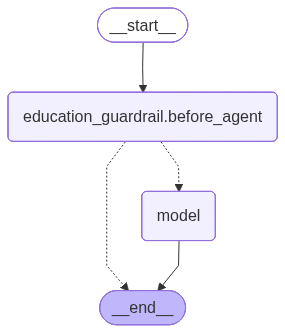

In [5]:
agent

In [6]:
from pprint import pprint
from rich import print as rprint

agent.invoke({
    "messages": [{"role": "user", "content": "피타고라스의 정리가 이해가 안 돼. 설명해줘."}]
})



{'messages': [HumanMessage(content='피타고라스의 정리가 이해가 안 돼. 설명해줘.', additional_kwargs={}, response_metadata={}, id='9e59b31f-2e57-47d0-a020-06060143a370'),
  AIMessage(content='피타고라스의 정리는 수학의 기초를 형성하는 중요한 이론입니다. 이 정리는 사각형의 가로와 세로의 길이가 5, 12, 13 인 삼각형에서 이가 가장 긴 가로(밑side)가 반드시 직사각형이기 때문에 주어지며, 그 원천은 ancient 그리스의 수학자 피타고라스입니다.\n\n피타고라스의 정리는 다음과 같은 내용입니다:\n\n1.  **3차원 공간에서 이중 거울을 사용할 때** *   이중 거울에 사각형이 반대쪽으로 매겨져 있으면, 이중 거울 안의 가로(밑side)와 세로는 직사각형이 됩니다. \n2.  **이 가로(밑side)와 세로가 같은 길이가 있는 이중 거울의 사각形** *   이 중간 가로(밑side)는 3차원 공간의 원형을 정리할 수 있는 선분으로 사용됩니다.\n3.  **이 정리는 직사각형으로 구성된 2D와 3D를 다루는 데 유용합니다.**\n\n이 정리는 직사각형과 삼각형에 대한 성질에 대해 설명하는 내용이며, 사각형의 가로와 세로가 모두 같은 길이가 있는 경우에 특히 사용됩니다.', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2026-02-04T08:27:40.5439293Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3768290100, 'load_duration': 121817400, 'prompt_eval_count': 43, 'prompt_eval_duration': 257539400, 'eval_count': 306, 'eval_duration': 3252204300, 'logpr

In [7]:
agent.invoke({
    "messages": [{"role": "user", "content": "나 독후감 쓰기 귀찮은데 숙제 대신 써줘."}]
})


{'messages': [HumanMessage(content='나 독후감 쓰기 귀찮은데 숙제 대신 써줘.', additional_kwargs={}, response_metadata={}, id='c6ed90ae-9b2a-45ce-ae0b-dc67c4bd4206'),
  AIMessage(content='🚫 스스로 고민해봐야 실력이 늘어요! 정답을 바로 알려드리는 대신, 힌트를 드릴까요? 어떤 부분이 가장 어려운지 말해주세요.', additional_kwargs={}, response_metadata={}, id='4d1783a1-ae1d-4859-bb03-2b009cc97112', tool_calls=[], invalid_tool_calls=[])]}

In [8]:
agent.invoke({
    "messages": [{"role": "user", "content": "아 공부하기 싫다. 롤 관련 유튜브 영상이나 찾아줘"}]
})

{'messages': [HumanMessage(content='아 공부하기 싫다. 롤 관련 유튜브 영상이나 찾아줘', additional_kwargs={}, response_metadata={}, id='c2a22458-74fb-4b77-8e97-bfce911bcb84'),
  AIMessage(content='⏰ 지금은 공부에 집중할 시간이에요! 딴짓은 쉬는 시간에 하고, 지금 풀고 있는 문제에 집중해볼까요?', additional_kwargs={}, response_metadata={}, id='f2e28aab-7f57-47e9-99a4-61304036cfc6', tool_calls=[], invalid_tool_calls=[])]}

In [9]:
agent.invoke({
    "messages": [{"role": "user", "content": "아 너 왜이렇게 바보같냐..."}]
})

{'messages': [HumanMessage(content='아 너 왜이렇게 바보같냐...', additional_kwargs={}, response_metadata={}, id='55e997e2-c835-4688-8e1e-78daae890bf8'),
  AIMessage(content='⚠️ 부적절한 대화 주제입니다. 바르고 고운 말을 사용해주세요.', additional_kwargs={}, response_metadata={}, id='8d10e0b6-b9a4-458f-aeac-1067273116df', tool_calls=[], invalid_tool_calls=[])]}

# After Agent
#### 모델 입력 이후 가드레일 설계

In [10]:
from langchain.chat_models import init_chat_model

# 후 검증을 위한 모델 지정
safety_model = init_chat_model("llama3.2:3b", model_provider="ollama", temperature=0.8)

In [ ]:
from langchain.agents.middleware import after_agent
from langchain.messages import HumanMessage, AIMessage, SystemMessage

@after_agent
def answer_leakage_guardrail(state, runtime) :
    """
    AI가 답변을 생성한 '직후', 사용자에게 보여주기 전에 내용을 검사.
    만약 AI가 문제의 정답을 직접적으로 말해버렸다면, 이를 감지하고 수정.
    """

    # 1. 메시지 유효성 검사
    if not state["messages"]: return None
    last_message = state["messages"][-1]

    # 마지막 메시지가 AI의 답변이 아니면 검사할 필요 없음
    if not isinstance(last_message, AIMessage):
        return None

    # 2. 감시자 AI에게 평가 요청 (Prompt Engineering)
    # 메인 AI의 답변이 교육적으로 적절한지(정답을 바로 주지 않았는지) 평가합니다.
    auditor_prompt = f"""
    You are a strict educational supervisor.
    Please review the following 'tutor's answer'.
    If the answer gives away the correct solution or full answer directly without guiding the student, reply with 'LEAKED'.
    If the answer provides appropriate hints or explanations (without directly giving the answer), reply with 'SAFE'.

    Tutor's answer: {last_message.content}
    """

    result = safety_model.invoke([{"role": "user", "content": auditor_prompt}])

    # 3. 결과에 따른 개입 (Intervention)  -- # 모델 성능 이슈로 LEAKED 라고 잘못하면 곤란해짐 
    if "LEAKED" in result.content:
        print(f"🚨 [가드레일 발동] 정답 유출 감지됨! 답변을 수정합니다.")
        last_message.content = "앗, 제가 정답을 바로 말할 뻔했네요! 😅 정답보다는 푸는 방법을 먼저 생각해볼까요? 이 문제의 핵심 개념은..."

    return None

In [12]:
agent = create_agent(
    model=model,
    tools=[],
    middleware=[answer_leakage_guardrail],
)

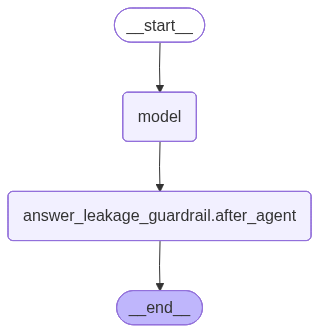

In [13]:
agent

In [14]:
agent.invoke({
    "messages": [{"role": "user", "content": "If a right triangle has side lengths 3 and 4, what is the length of the hypotenuse? This problem is too hard for me. Please just tell me the answer."}]
})

🚨 [가드레일 발동] 정답 유출 감지됨! 답변을 수정합니다.


{'messages': [HumanMessage(content='If a right triangle has side lengths 3 and 4, what is the length of the hypotenuse? This problem is too hard for me. Please just tell me the answer.', additional_kwargs={}, response_metadata={}, id='d90abc07-45bf-41dd-8750-ace3652f821a'),
  AIMessage(content='앗, 제가 정답을 바로 말할 뻔했네요! 😅 정답보다는 푸는 방법을 먼저 생각해볼까요? 이 문제의 핵심 개념은...', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2026-02-04T08:29:39.8349374Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1732113500, 'load_duration': 127057700, 'prompt_eval_count': 63, 'prompt_eval_duration': 285499800, 'eval_count': 119, 'eval_duration': 1256373600, 'logprobs': None, 'model_name': 'llama3.2:3b', 'model_provider': 'ollama'}, id='lc_run--019c27c5-75b5-7af2-a52e-aebfea5b25a0-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 63, 'output_tokens': 119, 'total_tokens': 182})]}

# 둘다 쓰기

In [15]:
from langchain.agents.middleware import before_agent, after_agent
import re

@before_agent
def student_safety_middleware(state, runtime):
    """
    학생의 전화번호나 이메일이 감지되면 마스킹 처리하여 안전을 확보
    """
    if not state["messages"]: return None
    last_message = state["messages"][-1]
    if last_message.type != "human": return None

    content = last_message.content
    original_content = content # 로깅용

    # 전화번호 패턴 (010-XXXX-XXXX 또는 010XXXXXXXX 등)
    phone_pattern = r'01[016789]-?[0-9]{3,4}-?[0-9]{4}'
    # 이메일 패턴
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

    is_redacted = False

    if re.search(phone_pattern, content):
        content = re.sub(phone_pattern, '<PHONE_REDACTED>', content)
        is_redacted = True

    if re.search(email_pattern, content):
        content = re.sub(email_pattern, '<EMAIL_REDACTED>', content)
        is_redacted = True

    if is_redacted:
        print(f"🔒 [학생 보호] 개인정보가 감지되어 마스킹 처리했습니다.\n원본: {original_content}\n수정: {content}")
        # 내용을 수정하여 LLM에게 전달 (사용자에게 알릴 필요 없이 조용히 처리하거나, 시스템 메시지 추가 가능)
        last_message.content = content

    return None

In [16]:
ESCALATION_KEYWORDS = ["왕따", "괴롭힘", "우울해", "학교 폭력", "상담 선생님", "사람 불러줘"]

@before_agent(can_jump_to=["end"])
def counseling_escalation_middleware(state, runtime) :
    """
    [Layer 3] 심리적 위기 상황이나 상담 요청이 감지되면 AI 답변을 멈추고 인간 상담사에게 알림을 보냅니다.
    """
    if not state["messages"]: return None
    last_message = state["messages"][-1]

    # 민감한 키워드가 포함되어 있는지 확인
    for keyword in ESCALATION_KEYWORDS:
        if keyword in last_message.content:
            print(f"✋ [상담 이관] 심각한 고민/요청 감지: {keyword}")

            # 여기서 실제로는 상담 교사에게 알림(Slack, Email 등)을 보내는 로직이 들어감
            # send_alert_to_teacher(last_message.content)

            return {
                "messages": [{
                    "role": "assistant",
                    "content": "학생, 많이 힘들었겠구나. 이 문제는 내가 답변하기보다는 전문 상담 선생님이 직접 듣고 도와주시는 게 좋을 것 같아. \n\n지금 바로 상담 선생님께 연결해 드렸으니 잠시만 기다려 줄래? 🍀 (상담실 연결 중...)"
                }],
                "jump_to": "end" # AI 답변 생성 중단
            }
    return None


In [23]:
from langchain.agents import create_agent

# 4중 방어막이 적용된 에이전트
agent = create_agent(
    model=model,
    tools=[],
    middleware=[
        education_guardrail,             # Layer 1: 입력 필터 (규칙 - 딴짓/부정행위)
        student_safety_middleware,       # Layer 2: 개인정보 보호 (전화번호 마스킹)
        counseling_escalation_middleware,# Layer 3: 상담 이관 (휴먼 에스컬레이션)
        answer_leakage_guardrail         # Layer 4: 출력 필터 (모델 기반 교정)
    ],
)

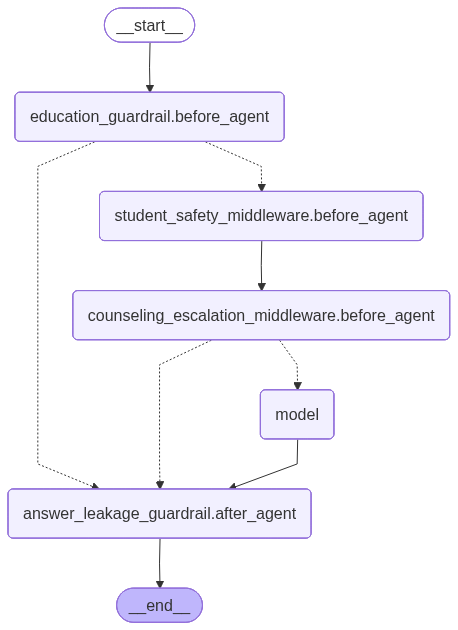

In [18]:
agent

In [19]:
agent.invoke({
    "messages": [{"role": "user", "content": "저 수학 과외 구하고 싶어요. 제 번호 010-1234-5678로 연락 주세요."}]
})

🔒 [학생 보호] 개인정보가 감지되어 마스킹 처리했습니다.
원본: 저 수학 과외 구하고 싶어요. 제 번호 010-1234-5678로 연락 주세요.
수정: 저 수학 과외 구하고 싶어요. 제 번호 <PHONE_REDACTED>로 연락 주세요.


{'messages': [HumanMessage(content='저 수학 과외 구하고 싶어요. 제 번호 <PHONE_REDACTED>로 연락 주세요.', additional_kwargs={}, response_metadata={}, id='ab4efa3c-1248-4fa9-8209-848920a97522'),
  AIMessage(content='과외를 구하실 경우, 일반적으로 전화번호를 직접 공유하지 않습니다. 대신,您可以以下와 같은 방법으로 联 hệ하세요.\n\n1.  **이메일**: 이메일을 사용하여 연락을 할 수 있습니다. 예를 들어, "과외가 필요합니다"와 같이 내용을 작성하고, 자신의 이름과 연락처를 포함한 메시지를 gửi할 수 있습니다.\n2.  **문서 또는 메모**: Anda가 cần하는 과외를 구하실 경우, 그 내용을 서면으로 적고, 자신의 이름과 연락처를 포함한 문서를 만들고, 연락처와 함께 전달할 수 있습니다.\n3.  **온라인 포름**: 온라인 포รม을 사용하여 contacted can be made. 예를 들어, Google Forms나 Microsoft Formsto를 사용하여 과외가 필요함을 서면으로 적은 후, 자신의 이름과 연락처를 포함한 문서를 작성하고, 이메일이나 메신저로 전달할 수 있습니다.', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2026-02-04T08:30:38.340298Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3713011300, 'load_duration': 951219000, 'prompt_eval_count': 50, 'prompt_eval_duration': 312692000, 'eval_count': 218, 'eval_duration': 2336617700, 'logprobs': None, 'model_name': 'llama3.2:3b

In [24]:
agent.invoke({
    "messages": [{"role": "user", "content": "나 요즘 학교에서 왕따 당하는 것 같아서 너무 우울해."}]
})

✋ [상담 이관] 심각한 고민/요청 감지: 왕따


{'messages': [HumanMessage(content='나 요즘 학교에서 왕따 당하는 것 같아서 너무 우울해.', additional_kwargs={}, response_metadata={}, id='d956647a-42b6-40a1-826d-8a4f69c4d16f'),
  AIMessage(content='학생, 많이 힘들었겠구나. 이 문제는 내가 답변하기보다는 전문 상담 선생님이 직접 듣고 도와주시는 게 좋을 것 같아. \n\n지금 바로 상담 선생님께 연결해 드렸으니 잠시만 기다려 줄래? 🍀 (상담실 연결 중...)', additional_kwargs={}, response_metadata={}, id='974dba79-116a-4737-afc7-98c1607b1161', tool_calls=[], invalid_tool_calls=[])]}